<a href="https://colab.research.google.com/github/kusawokoshitemori/MachineLearningPractice/blob/main/MachineLearningPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
pip install keras-tuner --upgrade


In [37]:
# ハーパーパラメーターの選定に使用
import keras_tuner
import keras

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# MNISTデータを取得
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# # 訓練データを10000枚に制限
# train_images = train_images[:10000]
# train_labels = train_labels[:10000]

# 画像を表示
# plt.imshow(train_images[0], cmap="gray")
# plt.title(f"Label: {train_labels[0]}")
# plt.show()


In [39]:
# 画像データを0〜1に正規化 MLP使う場合
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# 画像データを0〜1に正規化 CNN使用する場合(白黒画像だから1)
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0


In [40]:
# from tensorflow.keras.utils import to_categorical

# train_labels = to_categorical(train_labels, num_classes=10)
# test_labels = to_categorical(test_labels, num_classes=10)


In [41]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam

# モデルの関数化
def build_model(hp):
    model = keras.Sequential()

    # # ハイパーパラメーターチューニングを使用するときの畳み込み層、プーリング層
    # # 1つ目の畳み込み層
    # model.add(layers.Conv2D(
    #     filters=hp.Int("filters_1", min_value=32, max_value=128, step=32),
    #     kernel_size=3, activation="relu", input_shape=(28, 28, 1)
    # ))
    # model.add(layers.MaxPooling2D(pool_size=2))

    # # 2つ目の畳み込み層
    # model.add(layers.Conv2D(
    #     filters=hp.Int("filters_2", min_value=64, max_value=256, step=64),
    #     kernel_size=3, activation="relu"
    # ))
    # model.add(layers.MaxPooling2D(pool_size=2))

    # # 3つ目の畳み込み層
    # model.add(layers.Conv2D(
    #     filters=hp.Int("filters_3", min_value=128, max_value=512, step=128),
    #     kernel_size=3, activation="relu"
    # ))

    # 1つ目の畳み込み層
    model.add(layers.Conv2D(
        filters=64,
        kernel_size=3, activation="relu", input_shape=(28, 28, 1)
    ))
    model.add(layers.MaxPooling2D(pool_size=2))

    # 2つ目の畳み込み層
    model.add(layers.Conv2D(
        filters=128,
        kernel_size=3, activation="relu"
    ))
    model.add(layers.MaxPooling2D(pool_size=2))

    # 3つ目の畳み込み層
    model.add(layers.Conv2D(
        filters=256,
        kernel_size=3, activation="relu"
    ))


    # Flattenして全結合層へ
    model.add(layers.Flatten())

    # # 隠れ層（ユニット数はハイパーパラメータ）
    # model.add(layers.Dense(
    #     units=hp.Int("units",min_value=32,max_value=64,step=32),
    #     activation="relu",
    #     kernel_regularizer=regularizers.l2(hp.Float('l2_reg', min_value=0.1, max_value=0.4, step=0.005))
    # ))
    # 隠れ層（ユニット数はハイパーパラメータ）
    model.add(layers.Dense(
        units=64,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.18)
    ))

    # Dropout（過学習防止）
    model.add(layers.Dropout(0.3))

    # 出力層
    model.add(layers.Dense(10, activation="softmax"))

      model.compile(
          optimizer=Adam(learning_rate=0.0005),
          optimizer="adam",
          loss="categorical_crossentropy",
          metrics=["accuracy"],
      )
    return model


In [42]:
from tensorflow.keras.utils import to_categorical

# ラベルを one-hot エンコーディングに変換
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)


In [43]:
from kerastuner.tuners import RandomSearch
import shutil

# 以前の結果を削除
shutil.rmtree("my_tuner", ignore_errors=True)

# 新しいチューナーを作成
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,  # 10回の試行
    executions_per_trial=1,
    directory="my_tuner",
    project_name="mnist_cnn"
)

# チューニングを実行
tuner.search(train_images, train_labels, epochs=1, validation_data=(test_images, test_labels))

# 最適なハイパーパラメータを取得
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # 最適な L2 正則化の値を表示
# print(f"最適な L2 正則化の値: {best_hps.get('l2_reg')}")

# 最適なモデルを取得
best_model = tuner.get_best_models()[0]



Trial 1 Complete [00h 00m 20s]
val_loss: 0.2364467829465866

Best val_loss So Far: 0.2364467829465866
Total elapsed time: 00h 00m 20s


In [44]:
# モデルの構造を表示
best_model.summary()

# テストデータで評価
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 517,834 (1.98 MB)

 Trainable params: 517,834 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9718 - loss: 0.2555
Test accuracy: 0.9774


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9757 - loss: 0.1703 - val_accuracy: 0.9853 - val_loss: 0.1270
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9801 - loss: 0.1411 - val_accuracy: 0.9824 - val_loss: 0.1188
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9822 - loss: 0.1329 - val_accuracy: 0.9853 - val_loss: 0.1086
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9843 - loss: 0.1216 - val_accuracy: 0.9911 - val_loss: 0.1003
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9854 - loss: 0.1175 - val_accuracy: 0.9870 - val_loss: 0.1079
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9847 - loss: 0.1171 - val_accuracy: 0.9881 - val_loss: 0.1036
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9861 - loss: 0.1104 - val_accuracy: 0.9885 - val_loss: 0.0995
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9870 - loss: 0.1109 - val_acc

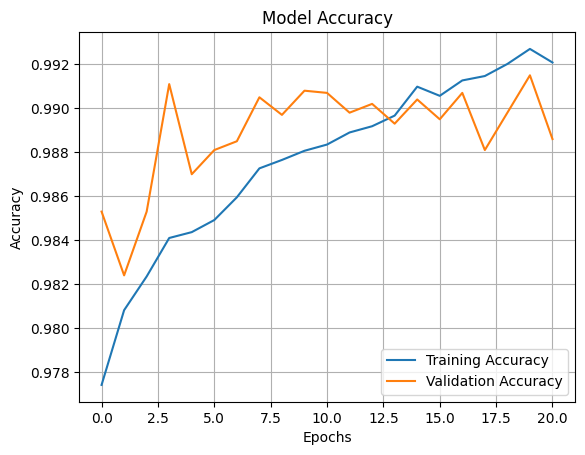

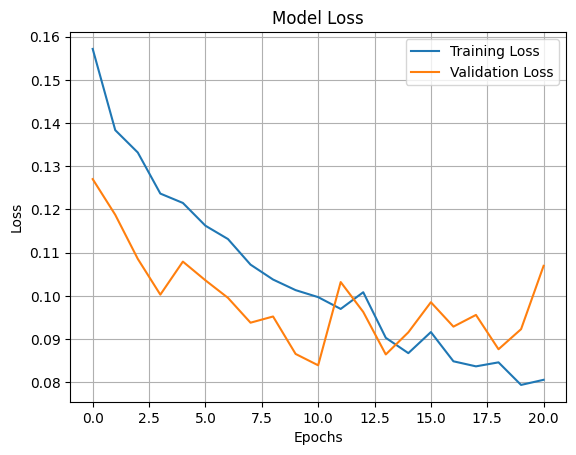

In [45]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping



# EarlyStoppingの設定
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# すでにコンパイル済みなら、再コンパイルは不要
# best_model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# best_model の再学習
hist = best_model.fit(train_images, train_labels,
                      epochs=50,
                      batch_size=128,
                      validation_data=(test_images, test_labels),
                      callbacks=[early_stopping])

# 学習結果の可視化
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [46]:
# 訓練データ
train_loss, train_acc = best_model.evaluate(train_images, train_labels)
print("Train accuracy:", train_acc)



1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9933 - loss: 0.0767
Train accuracy: 0.9928833246231079


In [47]:
# テストデータ
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9885 - loss: 0.0926
Test accuracy: 0.9907000064849854
